In [24]:
import sys
sys.path.append('..')
from db2 import *

In [25]:
import pandas as pd
from IPython.display import display, Latex

data = {
    'Sets': [r"A: F \ni e; F \setminus e \in L(M)", 
             r"D: F \ni e; F \setminus e \notin L(M)",
             r"C: F \notni e; F \cup e \in L(M)",
             r"B: F \notni e; F \cup e \notin L(M)"],
    'rk(M|F)-rk(M\'|F\')': [1, 0, 0, 0],
    'rk(M/F)-rk(M\'/F\')': [-1, 0, 0, 0],
    'M|F \\cong M\'|F\'': [False, False, True, True],
    'M/F \\cong M\'/F\'': [False, True, False, True],
}

df = pd.DataFrame(data)

# Display the dataframe with LaTeX support
display(Latex(df.to_html(escape=False)))

<IPython.core.display.Latex object>

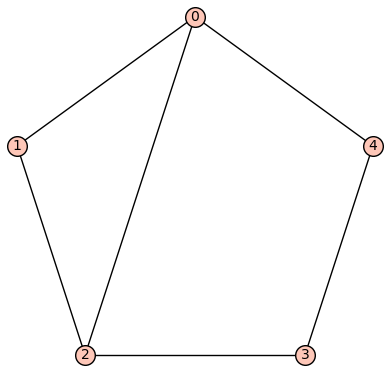

frozenset({(0, 2)})

In [26]:
#creating parallel connection of cycles
m, n = 3, 4

def parallel_connection(m, n):
    G = graphs.CycleGraph(m + n - 2)
    G.add_edge(0, m-1)
    edge_e = frozenset({(0, m - 1)})
    return G, edge_e

G, edge_e = parallel_connection(m, n)
G.show()
M = Matroid(G)

#M = matroids.Wheel(3)
#edge_e = frozenset({0})


flats = M.lattice_of_flats().list()
gset = M.groundset()
labels = {element: idx for idx, element in enumerate(gset)}
relabel_flats = {flat: frozenset({labels[element] for element in flat}) for flat in flats}
edge_e

In [27]:
def invKL(M):
    L = M.lattice_of_flats()
    if M.rank() == 0:
        return R(1)
    invKLpoly = sum((-1) ** M.delete(M.groundset()-L[i]).rank() * 
                    kl(M.delete(M.groundset()-L[i])) * 
                    invKL(M.contract(L[i])) 
                    for i in range(1, len(M.lattice_of_flats())))
    return -invKLpoly

def kl(M):
    return M.lattice_of_flats().kazhdan_lusztig_polynomial()(t)

kl_inverse_fast(M)

-25.0*t - 10.0

In [28]:
def set_division(M, e):
    L = M.lattice_of_flats()
    divs = {'A': set(), 'B': set(), 'C': set(), 'D': set()}
    for x in L[1:]:
        if set(e).issubset(set(x)):
            if frozenset(set(x) - set(e)) in L:
                divs['A'].add(x)
            else:
                divs['D'].add(x)
        else:
            if frozenset(set(x) | set(e)) in L:
                divs['C'].add(x)
            else:
                divs['B'].add(x)
    return divs

divs = set_division(M, edge_e)
divs_deletion = {x: set(frozenset(set(y) - set(edge_e)) for y in divs[x]) for x in divs}

for key, value in divs.items():
    print(f"{key}: {[relabel_flats[v] for v in value]}")

A: [frozenset({3, 5}), frozenset({4, 5}), frozenset({5}), frozenset({2, 5})]
B: [frozenset({2, 3}), frozenset({0, 3, 4}), frozenset({0, 4}), frozenset({1, 2, 4}), frozenset({3, 4}), frozenset({0, 2}), frozenset({0}), frozenset({0, 2, 3}), frozenset({1, 3}), frozenset({1, 3, 4}), frozenset({1, 4}), frozenset({0, 2, 4}), frozenset({1}), frozenset({1, 2, 3}), frozenset({0, 3}), frozenset({1, 2}), frozenset({2, 4})]
C: [frozenset({3}), frozenset({2}), frozenset({4})]
D: [frozenset({0, 1, 4, 5}), frozenset({0, 1, 2, 5}), frozenset({2, 3, 4, 5}), frozenset({0, 1, 3, 5}), frozenset({0, 1, 2, 3, 4, 5}), frozenset({0, 1, 5})]


In [29]:
deletion_flats = M.delete(edge_e).lattice_of_flats().list()

relabel_flats_deletion = {flat: frozenset({labels[element] for element in flat}) for flat in deletion_flats}

for key, value in divs_deletion.items():
    print(f"{key}: {[relabel_flats_deletion[v] for v in value]}")

A: [frozenset({3}), frozenset({2}), frozenset(), frozenset({4})]
B: [frozenset({2, 3}), frozenset({0, 3, 4}), frozenset({0, 4}), frozenset({1, 2, 4}), frozenset({3, 4}), frozenset({0, 2}), frozenset({0}), frozenset({0, 2, 3}), frozenset({1, 3}), frozenset({1, 3, 4}), frozenset({1, 4}), frozenset({0, 2, 4}), frozenset({1}), frozenset({1, 2, 3}), frozenset({0, 3}), frozenset({1, 2}), frozenset({2, 4})]
C: [frozenset({3}), frozenset({2}), frozenset({4})]
D: [frozenset({0, 1, 2, 3, 4}), frozenset({0, 1, 3}), frozenset({0, 1, 2}), frozenset({2, 3, 4}), frozenset({0, 1, 4}), frozenset({0, 1})]


In [30]:
def plotmatroid(m):
    return m.lattice_of_flats().plot(
        element_labels = relabel_flats, element_color = "white",
        figsize= 25, cover_color = "grey")

In [31]:
def sum_at_Subset(S, M):
    return sum((-1) ** M.rank(F) * kl(M.delete(M.groundset() - set(F))) * kl_inverse_fast(M.contract(F)) for F in S)

def isom_restriction(S, M, N, e):
    return sum((-1) ** M.rank(F) * kl(M.delete(M.groundset() - set(F))) * kl_inverse_fast(M.contract(F)) for F in S) -\
            sum((-1) ** N.rank(F - set(e)) * kl(N.delete(N.groundset() - (set(F) | {e}))) * kl_inverse_fast(N.contract(F - set(e))) for F in S)

def isom_contraction(S, M, N, e):
    return - sum((-1) ** M.rank(F) *
            (kl(N.delete(N.groundset() - (set(F) | {e}))) - kl(M.delete(M.groundset() - set(F)))) *
            kl_inverse_fast(M.contract(F)) for F in S)
    
results = {
        'Subset': [],
        'Sum at Subset': [],
        'Sum at Subset Deletion': [],
        'difference': [],
        'isom_restriction': [],
        'isom_contraction': []
    }

for x in divs:
    results['Subset'].append(x)
    results['Sum at Subset'].append(sum_at_Subset(divs[x], M))
    results['Sum at Subset Deletion'].append(sum_at_Subset(divs_deletion[x], M.delete(edge_e)))
    results['difference'].append(results['Sum at Subset'][-1] - results['Sum at Subset Deletion'][-1])
    results['isom_restriction'].append(isom_restriction(divs[x], M, M.delete(edge_e), edge_e))
    results['isom_contraction'].append(isom_contraction(divs[x], M, M.delete(edge_e), edge_e))

results_df = pd.DataFrame(results)
display(results_df)

,Subset,Sum at Subset,Sum at Subset Deletion,difference,isom_restriction,isom_contraction
0,A,1.0,-t - 5.0,t + 6.0,t + 6.0,0
1,B,12.0,-4.0*t + 6.0,4.0*t + 6.0,4.0*t + 6.0,0
2,C,-3.0*t - 12.0,-6.0*t - 9.0,3.0*t - 3.0,3.0*t - 3.0,0
3,D,2.0*t - 1.0,5.0*t - 1.0,-3.0*t,-3.0*t,-3.0*t


frozenset({(0, 1), (2, 3)}) 2.0 2


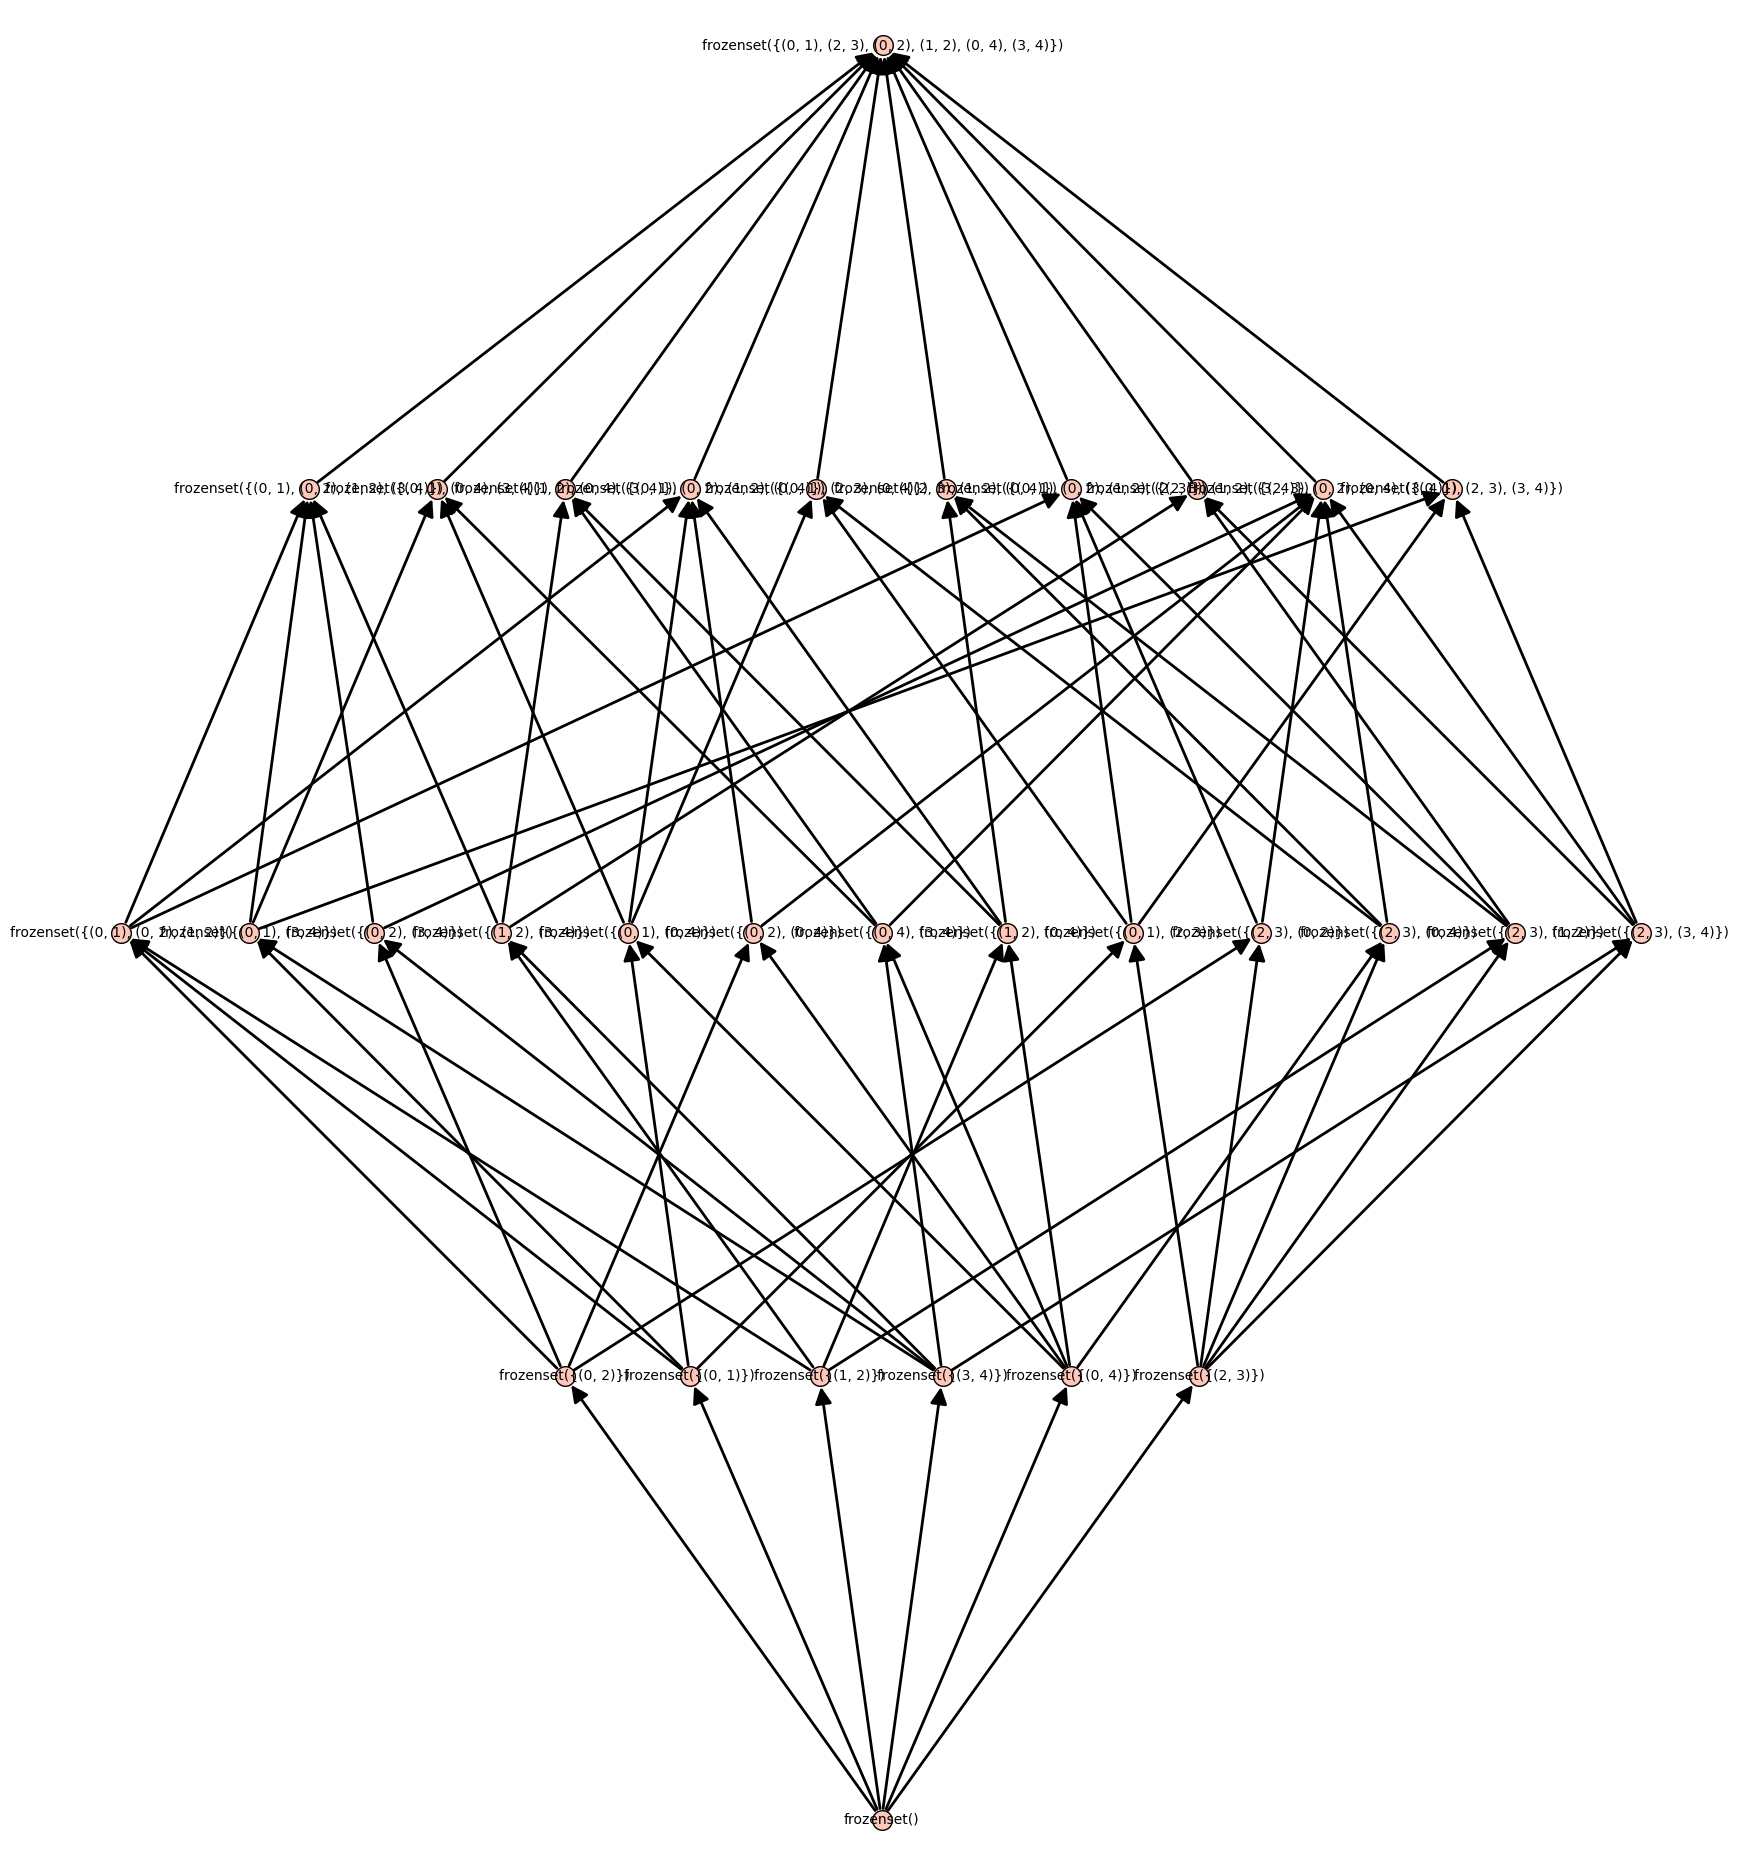

In [32]:
F = frozenset({(0, 1), (2, 3)})
print(F, kl_inverse_fast(M.contract(F)), invKL(M.contract(F)))
M.lattice_of_flats().plot(figsize= 25)

In [33]:
kl_inverse_fast(M) - kl_inverse_fast(M.delete(edge_e))

-30.0*t - 14.0

In [34]:
print(kl_inverse_fast(M))

s = -results['Sum at Subset'][0] - results['Sum at Subset'][2] - results['Sum at Subset'][3]

s += results['Sum at Subset Deletion'][0] + results['Sum at Subset Deletion'][3]
s

-25.0*t - 10.0


5.0*t + 6.0

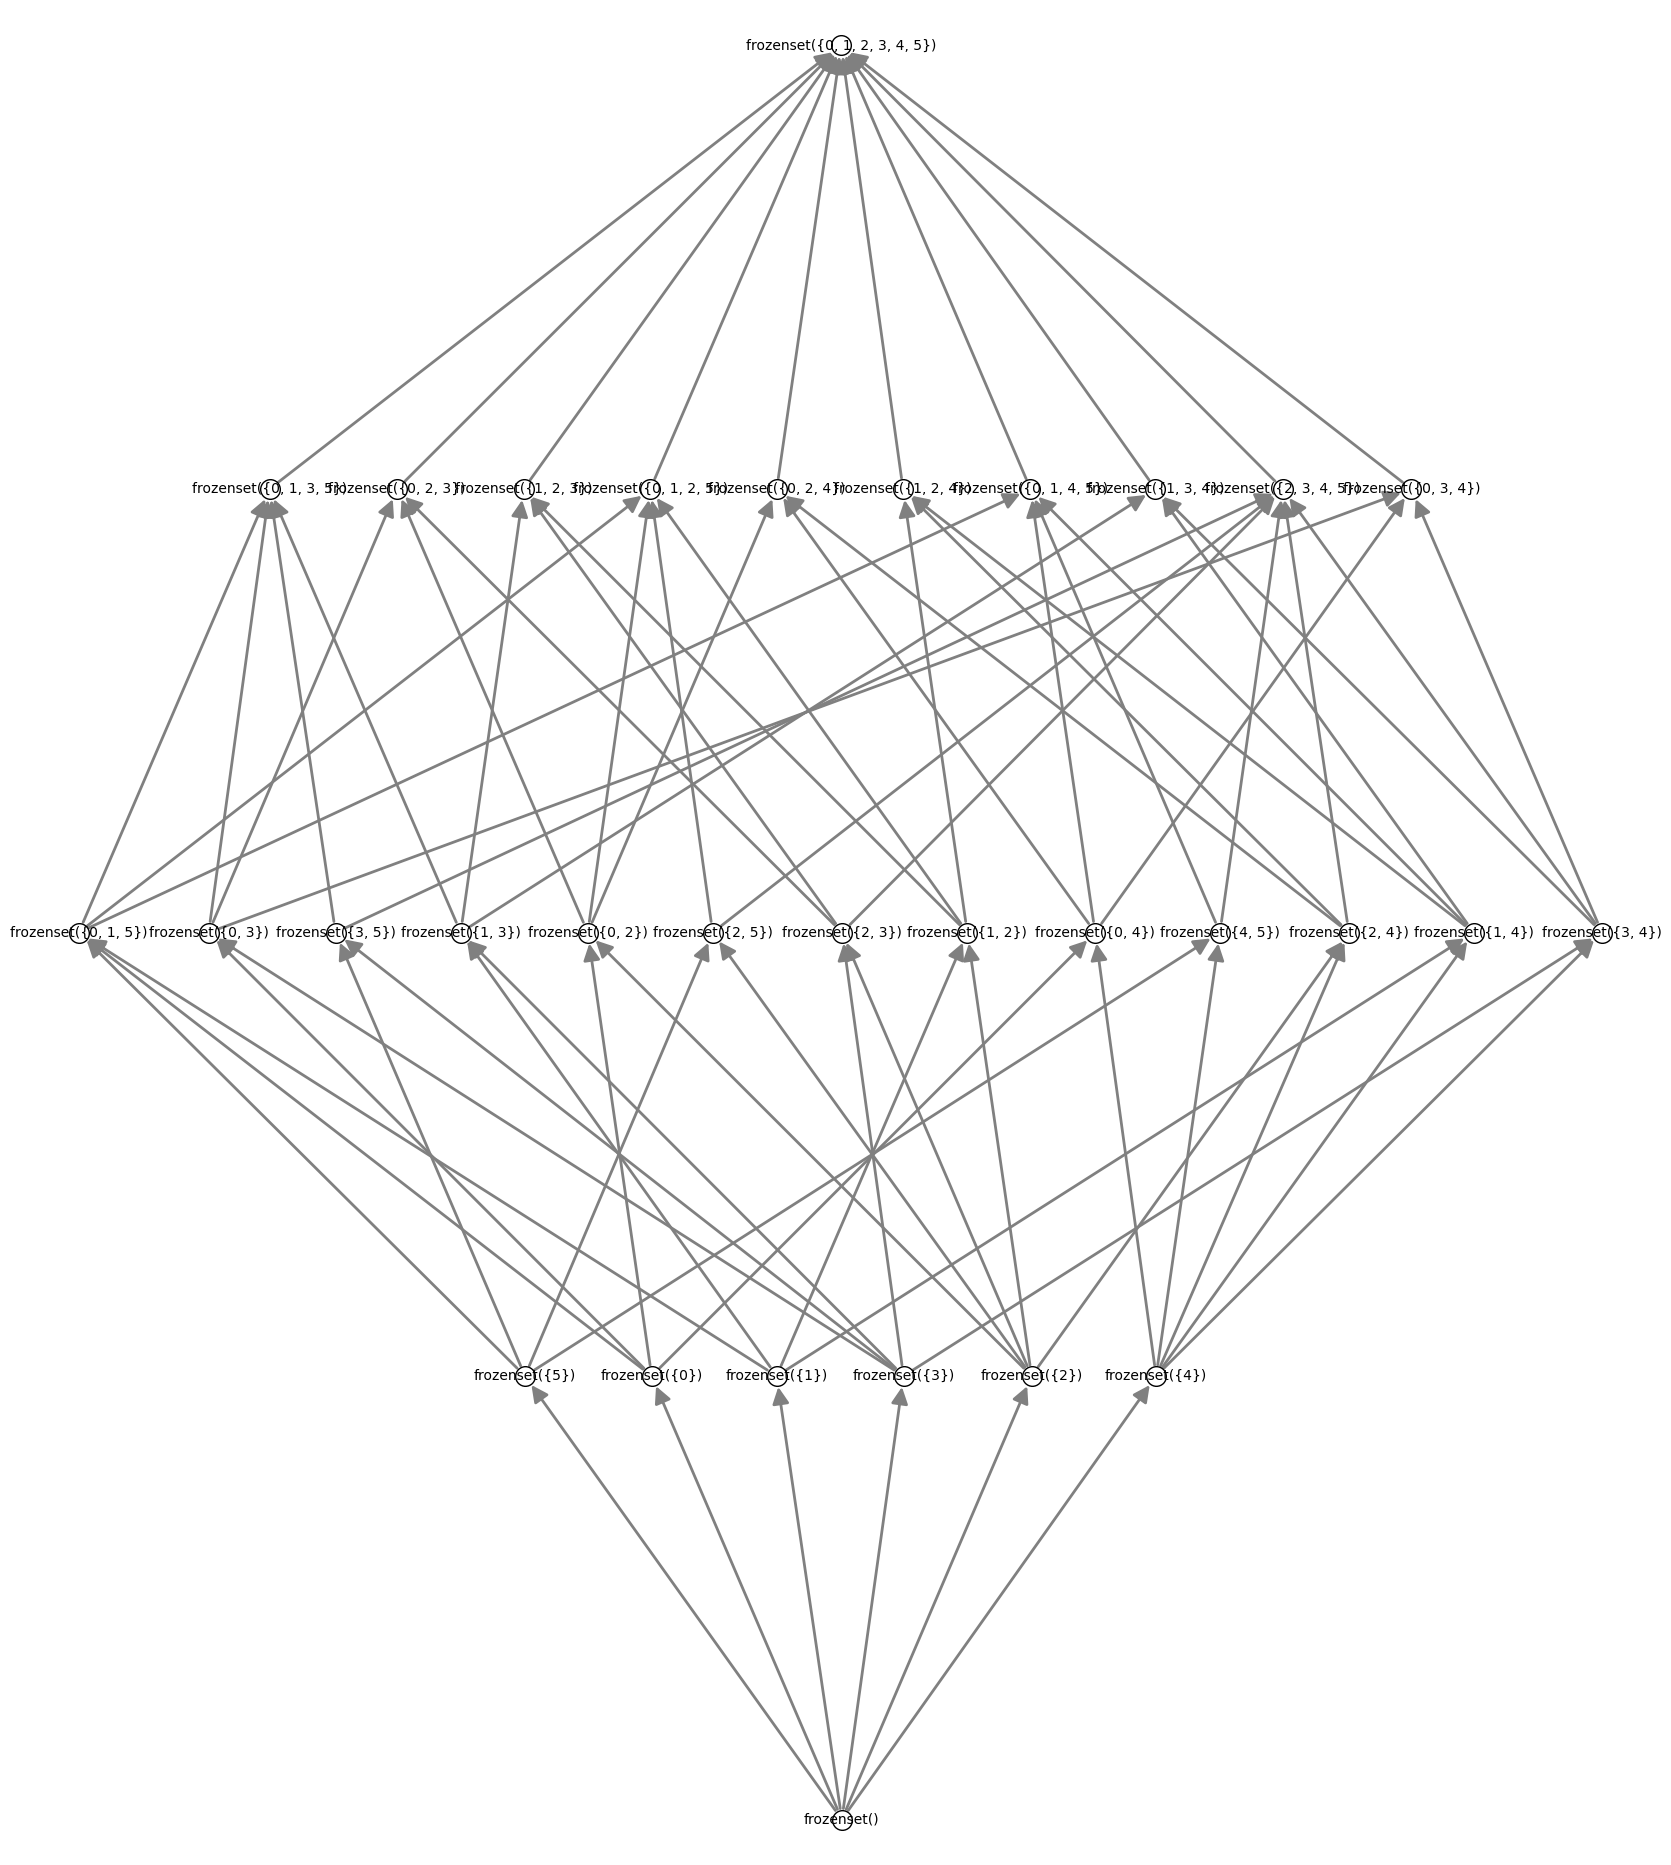

In [35]:
plotmatroid(M)